In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 18000
embedding_dim = 64
max_length = 120
filters = 100
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()


In [4]:
data = pd.read_csv("Twitter_Data.csv")
labels = data['Annotation']
texts = data['Tweets']
print(len(texts))
print(len(labels))

16907
16907


In [5]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_emoji = ''
    for char in text:
        if char not in emoji_list:
            no_emoji = no_emoji + char
        else:
            no_emoji = no_emoji + '<' + emoji.demojize(char) + '> '
    text = no_emoji
    
    text = re_sub(r"@\w+","<user>")
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct
    text = text.replace("  "," ")
    text = text.replace("\n"," ")
    return text.lower()


In [6]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

E:\Programs\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
print(texts[2213])

<user> <user> you are absolute scum


In [8]:
print(set(labels))

{'none', 'sexism', 'racism'}


In [9]:
divide = int(len(data)*training_portion)
train_tweets, validation_tweets, train_labels, validation_labels = texts[:divide], texts[divide:], labels[:divide], labels[divide:]
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))

13525
13525
3382
3382


In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

15060
13
120
22
120


In [11]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [12]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [13]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [17]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=0.002), metrics=['acc'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 64)           1152000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 118, 100)          19300     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 100)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 12s - loss: 0.6865 - acc: 0.7399 - val_loss: 0.4986 - val_acc: 0.8137
Epoch 2/10
13525/13525 - 11s - loss: 0.4431 - acc: 0.8281 - val_loss: 0.4645 - val_acc: 0.8247
Epoch 3/10
13525/13525 - 11s - loss: 0.3747 - acc: 0.8534 - val_loss: 0.4402 - val_acc: 0.8279
Epoch 4/10
13525/13525 - 11s - loss: 0.3340 - acc: 0.8703 - val_loss: 0.4444 - val_acc: 0.8300
Epoch 5/10
13525/13525 - 11s - loss: 0.3045 - acc: 0.8832 - val_loss: 0.4385 - val_acc: 0.8291
Epoch 6/10
13525/13525 - 11s - loss: 0.2774 - acc: 0.8950 - val_loss: 0.4503 - val_acc: 0.8279
Epoch 7/10
13525/13525 - 12s - loss: 0.2573 - acc: 0.9037 - val_loss: 0.4795 - val_acc: 0.8208
Epoch 8/10
13525/13525 - 12s - loss: 0.2460 - acc: 0.9094 - val_loss: 0.4723 - val_acc: 0.8199
Epoch 9/10
13525/13525 - 13s - loss: 0.2305 - acc: 0.9176 - val_loss: 0.4903 - val_acc: 0.8223
Epoch 10/10
13525/13525 - 13s - loss: 0.2201 - acc: 0.9210 - val_loss: 0.4892 - val_acc: 0.8140


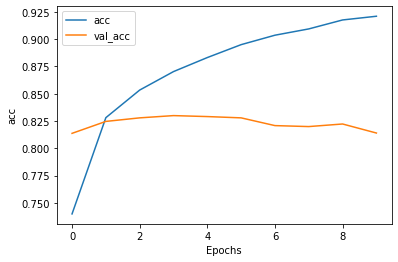

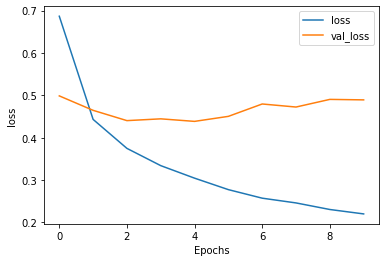

In [18]:
num_epochs = 10
history1 = model1.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

plot_graphs(history1, "acc")
plot_graphs(history1, "loss")